In [27]:
import pandas as pd
import os
import glob
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Markdown
import seaborn as sns
import numpy as np

from metadata.etfs import etfs_large, etfs_small
from utils.conn_data import load_pickle

plt.style.use('seaborn')

In [28]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
des = pd.read_csv(os.path.join(os.getcwd(), 'data', 'utils', 'fredmd_description.csv'), sep=';')

fs_methods = ["lasso", "multivariate-granger", "pairwise-granger", "var-lingam"] #, "dynotears"]
metric_names = ["stability", "mse", "mae"]
etf_focus = None
stability_threshold = 0.8
plot_ts = False

In [29]:
warnings.simplefilter("ignore")


all_metrics = []
all_rolling_metrics = []
all_stability = []
all_parents = []
for fs in fs_methods:

    if plot_ts:
        display(Markdown(f"## {fs}"))

    # list results files with glob
    results_files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", "*.pickle"))

    # load results files
    stability = []
    metrics = []
    for file in results_files:
        etf = file.split(fs)[-1].split("/")[-1].split("_")[0]

        if (etf_focus != etf) and (etf_focus is not None):
            continue
        else:
            pass

        obj = load_pickle(path=file)

        # plot predictions
        predictions_df = obj['predictions']
        predictions_2020_df = predictions_df.loc["2020-01-01":"2020-12-01"]

        if plot_ts:
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.set_title(label=f'OOS Predictions for {etf}', fontsize=15)
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["prediction"], label="predictions")
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["true"], label="true")
            plt.xlabel("Date")
            plt.ylabel("Returns")
            plt.legend(loc='best', fontsize=10)   
            plt.show()

        # compute rolling mse
        rolling_metric_df = predictions_df.copy()
        rolling_metric_df["diff"] = rolling_metric_df["true"] - rolling_metric_df["prediction"]

        # rolling mse
        rolling_metric_df["rolling_var"] = rolling_metric_df["prediction"].rolling(12).var()
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["true"] - rolling_metric_df["prediction"]).pow(2).rolling(12).mean()
        rolling_metric_df["rolling_mse"] = rolling_metric_df["rolling_var"] + rolling_metric_df["rolling_bias"] * 100
        rolling_metric_df["rolling_var"] = (rolling_metric_df["rolling_var"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["rolling_bias"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df = rolling_metric_df[["rolling_mse", "rolling_var", "rolling_bias"]]

        # add info
        rolling_metric_df["fs"] = fs
        rolling_metric_df["etf"] = etf

        # melt
        melt_rolling_metric_df = rolling_metric_df.reset_index().melt(["date", "fs", "etf"])

        # compute forecast metrics
        mse = mean_squared_error(predictions_df["true"], predictions_df["prediction"])
        mae = mean_absolute_error(predictions_df["true"], predictions_df["prediction"])
        mse_2020 = mean_squared_error(predictions_2020_df["true"], predictions_2020_df["prediction"])
        mae_2020 = mean_absolute_error(predictions_2020_df["true"], predictions_2020_df["prediction"])
        # bias = (predictions_df["true"] - np.mean(predictions_df["prediction"], axis=1)) ** 2
        # var = np.var(predictions_df["prediction"], axis=1)

        # compute cluster stability metrics
        parents_of_target_df = obj["parents_of_target"]

        # save parents
        parents_of_target_df["fs"] = fs
        parents_of_target_df["etf"] = etf
        
        tot = len(parents_of_target_df["date"].unique())
        stability_df = (parents_of_target_df.fillna(0).groupby(["cluster"]).sum()[["value"]] / tot).sort_values(by="value", ascending=False)
        stability_df = pd.concat({etf: stability_df}, names=['etf'])
        stability.append(stability_df)

        stability_measure = (stability_df).sum().iloc[0] / stability_df.shape[0]
        metrics_df = pd.DataFrame({
            "fs": fs, 
            "etf": etf, 
            "mse": [mse],
            "mae": [mae], 
            # "bias": [bias],
            # "var": [var],
            "mse_2020": [mse_2020], 
            "mae_2020": [mae_2020],
            "stability": stability_measure})
        metrics.append(metrics_df)
        all_rolling_metrics.append(melt_rolling_metric_df)
        all_parents.append(parents_of_target_df)
    
    all_metrics.append(pd.concat(metrics).set_index(["fs", "etf"]))
    all_stability.append(pd.concat(stability))
all_metrics_df = pd.concat(all_metrics)
all_rolling_metrics_df = pd.concat(all_rolling_metrics)
all_parents_df = pd.concat(all_parents)
melted_all_metrics_df = all_metrics_df.reset_index().melt(id_vars=["fs", "etf"])

## Boxplots with summary statistics

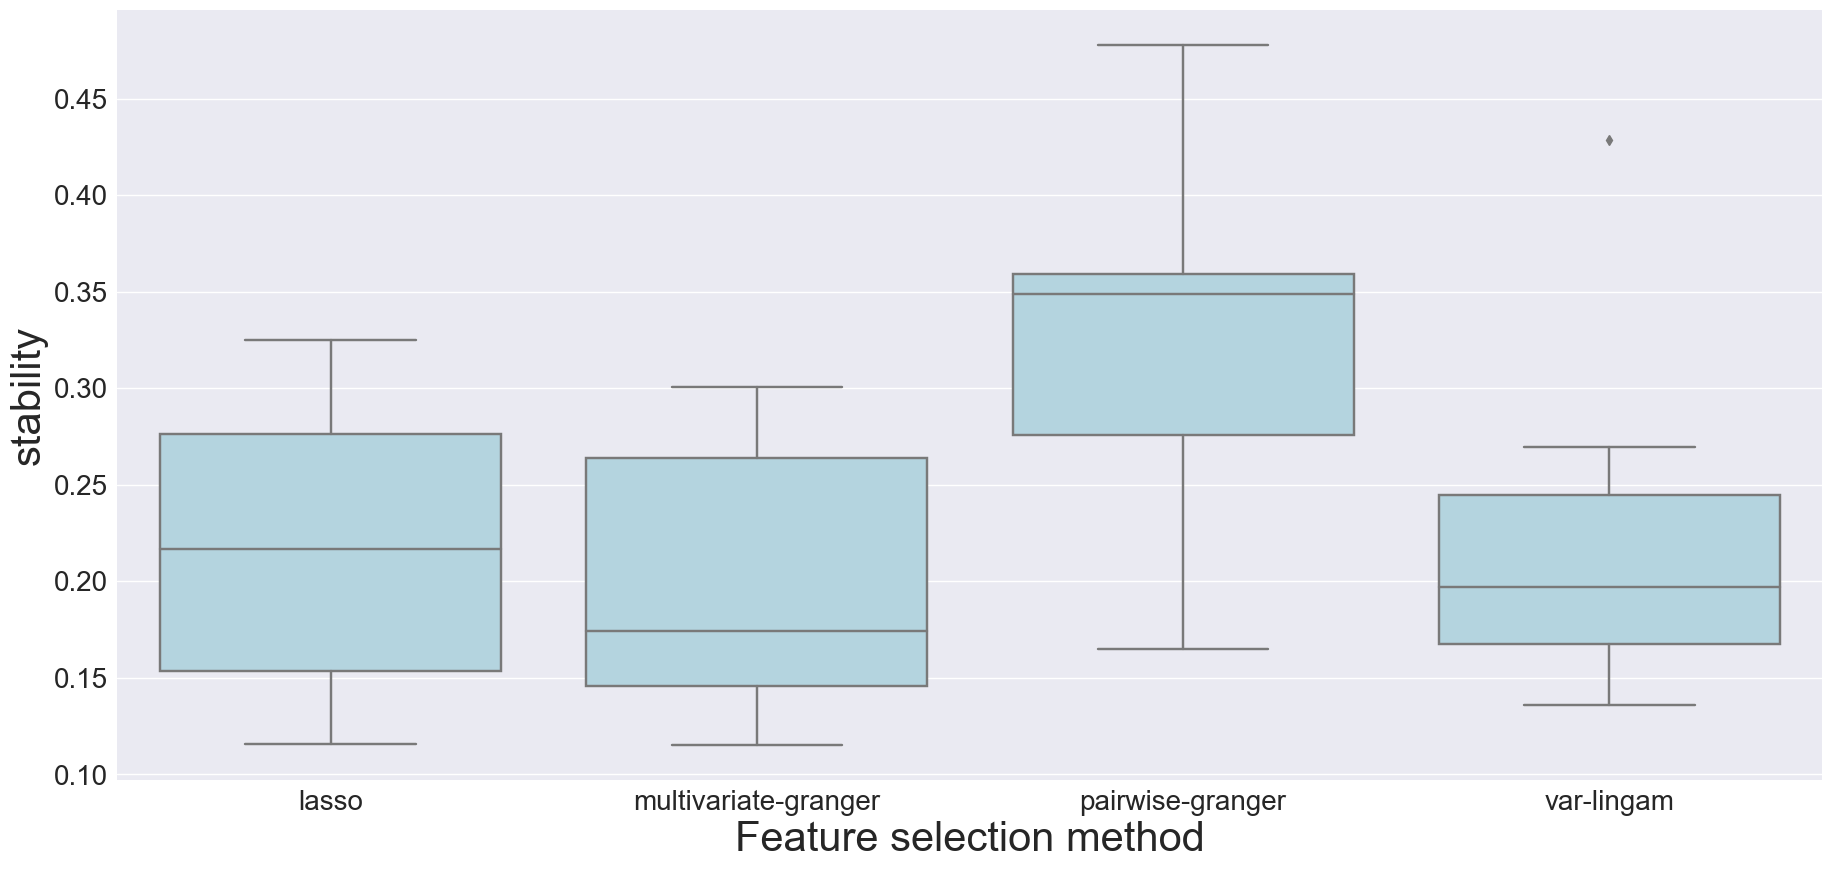

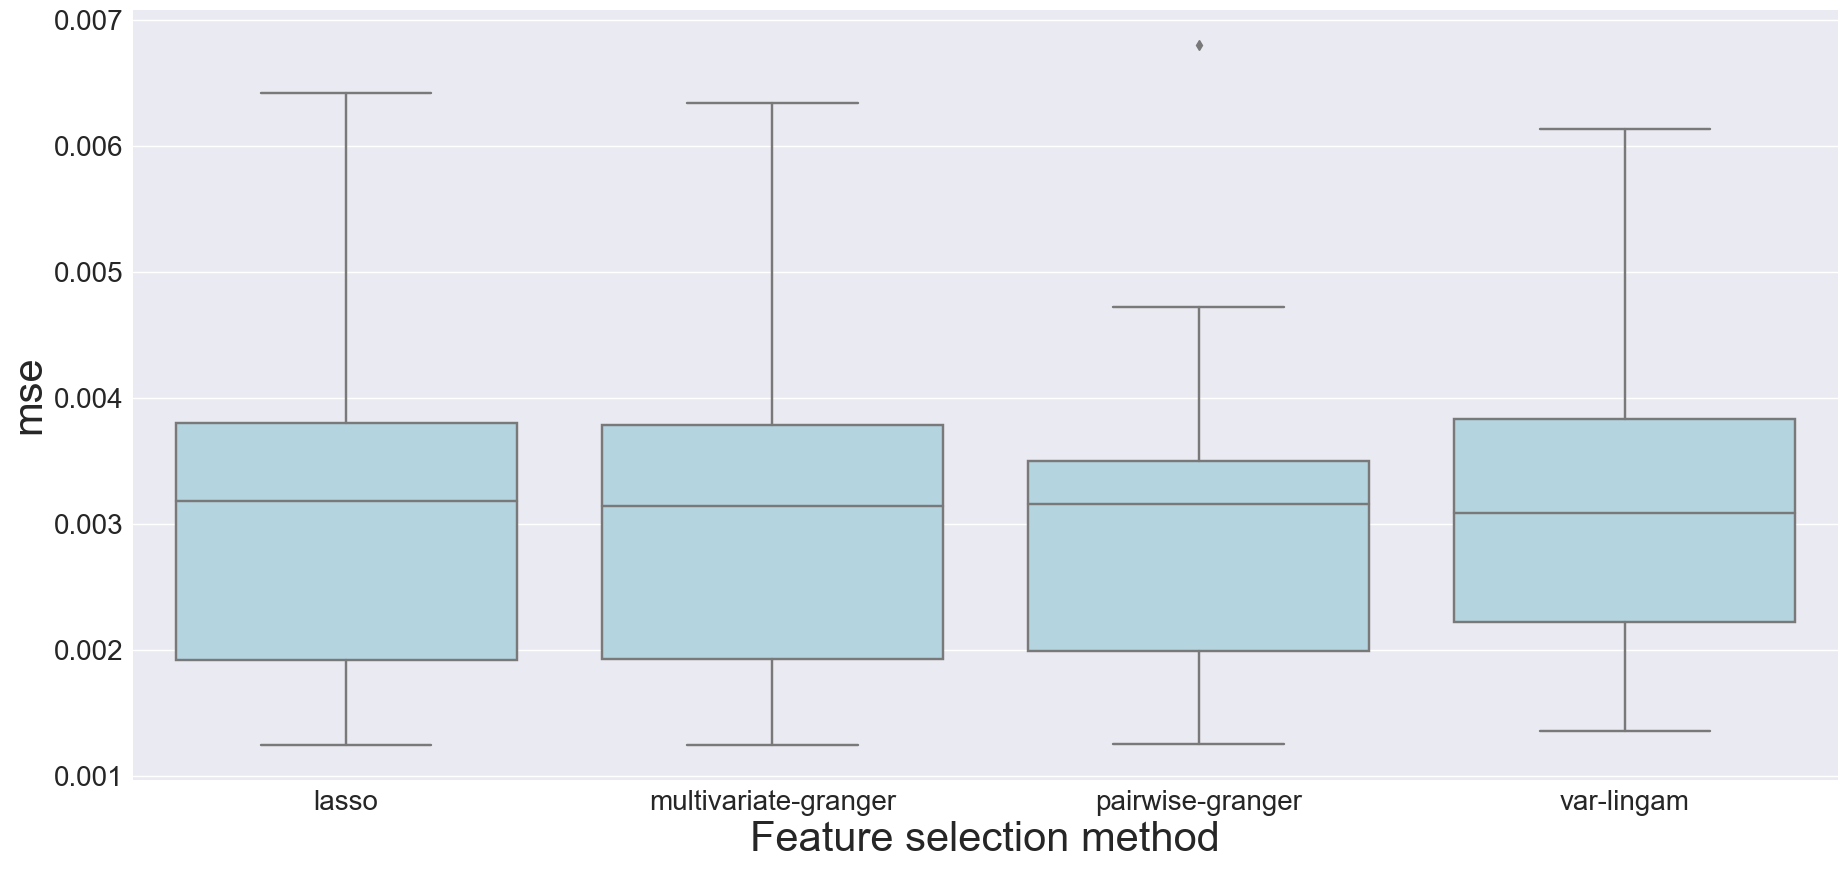

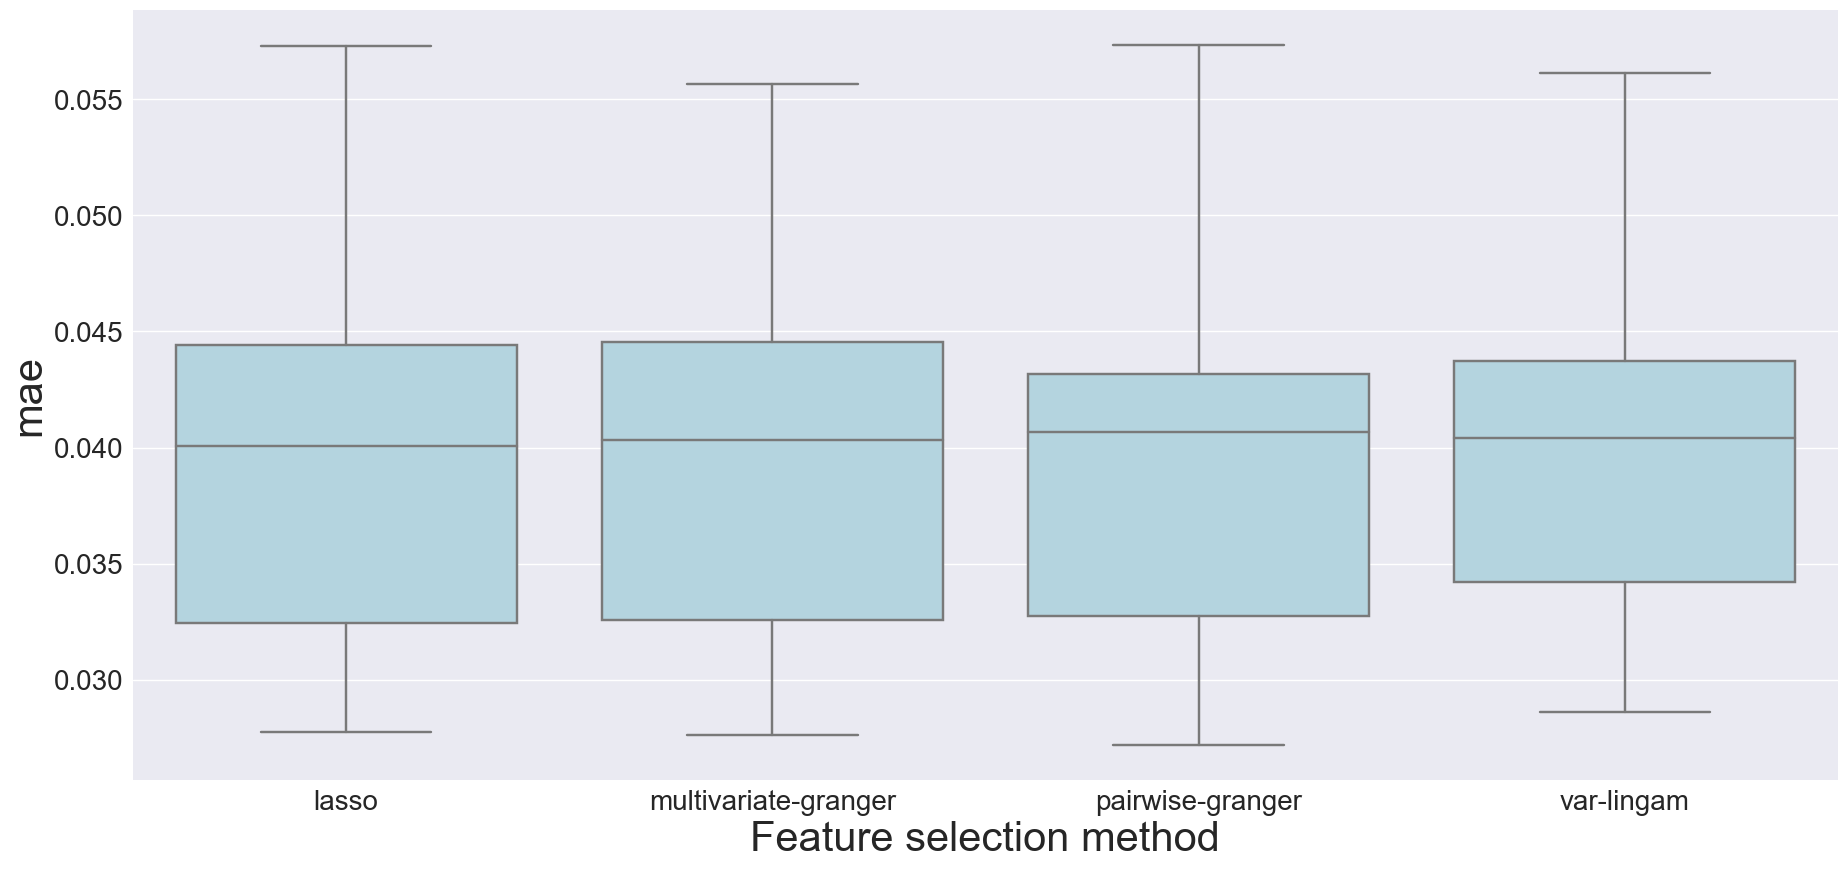

In [30]:
metric_name = "mse"
for m in metric_names:
    boxplot_df = melted_all_metrics_df.loc[(melted_all_metrics_df["variable"] == m)].drop(["variable"], axis=1)

    fig, ax = plt.subplots(figsize=(22, 10))
    sns.boxplot(x="fs", y='value',data=boxplot_df, ax=ax, color='lightblue')
    ax.set_ylabel(m, fontsize=30)
    ax.set_xlabel("Feature selection method", fontsize=30)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    # ax.legend(loc="best",fontsize=15)
    # fig.savefig('img/oos_auc_fs_methods_distr.png')

### Prediction error over time

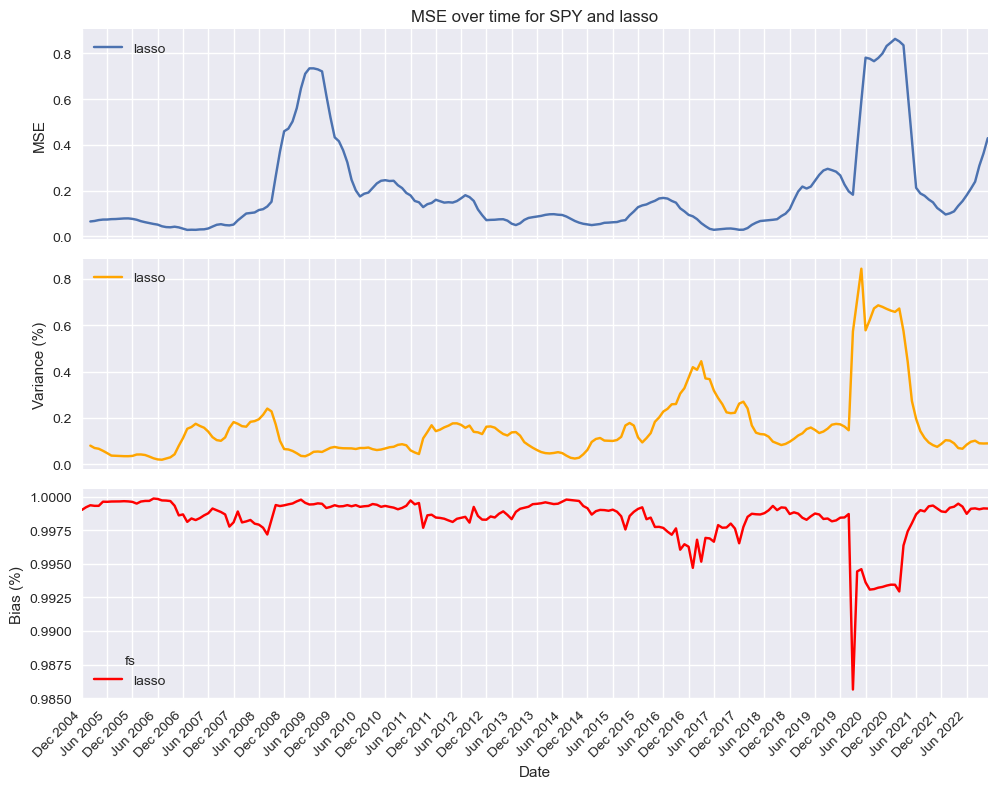

In [31]:
etf = "SPY"
fs = "lasso"

# mse
etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")].pivot_table(index=["date"], columns=["fs"], values=["value"])
etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
etf_rolling_metrics_df = etf_rolling_metrics_df.rolling(3).mean()
etf_rolling_metrics_df["diff_lasso_var-lingam"] = 1

# variance
etf_rolling_variance_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_var")].pivot_table(index=["date"], columns=["fs", "variable"], values=["value"])
etf_rolling_variance_df.columns = etf_rolling_variance_df.columns.droplevel()
etf_rolling_variance_df = etf_rolling_variance_df.rolling(3).mean()
etf_rolling_variance_df.columns = etf_rolling_variance_df.columns.droplevel(1) 

# bias
etf_rolling_bias_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_bias")].pivot_table(index=["date"], columns=["fs", "variable"], values=["value"])
etf_rolling_bias_df.columns = etf_rolling_bias_df.columns.droplevel()
etf_rolling_biass_df = etf_rolling_bias_df.rolling(3).mean()
etf_rolling_bias_df.columns = etf_rolling_bias_df.columns.droplevel(1) 

# plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# plotting on the upper subplot
etf_rolling_metrics_df.drop(["diff_lasso_var-lingam"], axis=1).plot(ax=axs[0])
axs[0].set_title(f'MSE over time for {etf} and {fs}')
axs[0].set_ylabel('MSE')
axs[0].legend(loc='upper left')

# plotting on the upper subplot
etf_rolling_variance_df.plot(ax=axs[1], color="orange")
# axs[1].set_title(f'Variance over time for {etf}')
axs[1].set_ylabel('Variance (%)')
axs[1].legend(loc='upper left')

# plotting on the lower subplot
etf_rolling_bias_df.plot(ax=axs[2], color="red")
# axs[2].set_title(f'Bias over time for {etf}')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Bias (%)')

# adding months and years to the index of the plot
tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
axs[2].set_xticks(tick_positions)
axs[2].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

# adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

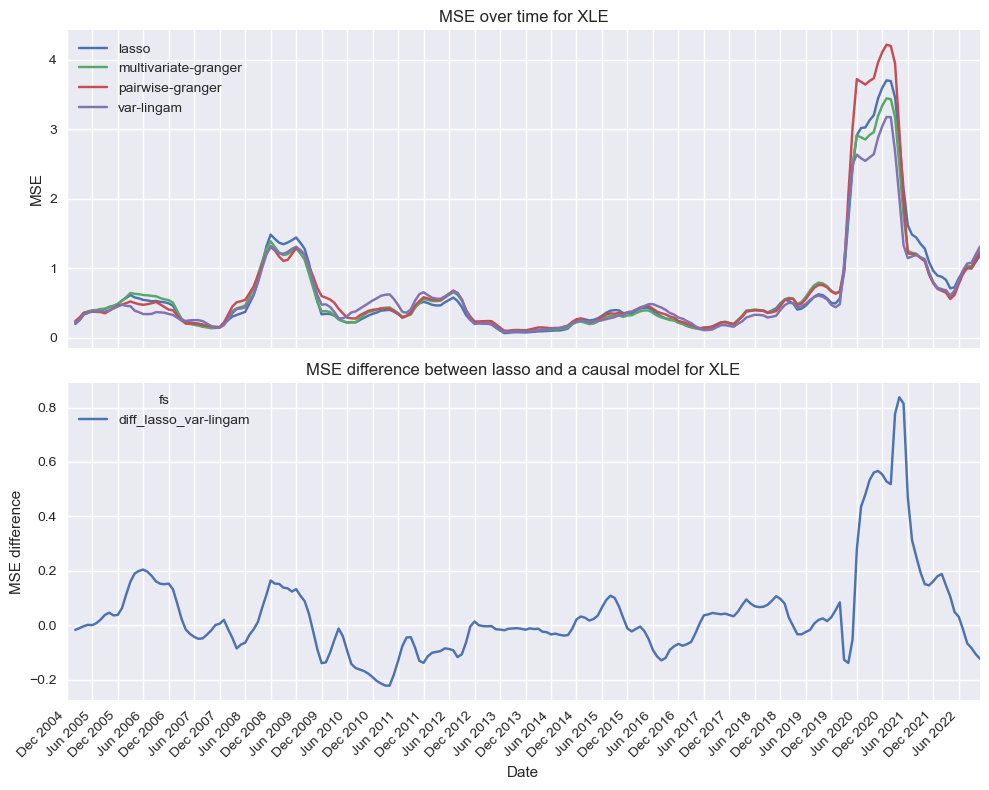

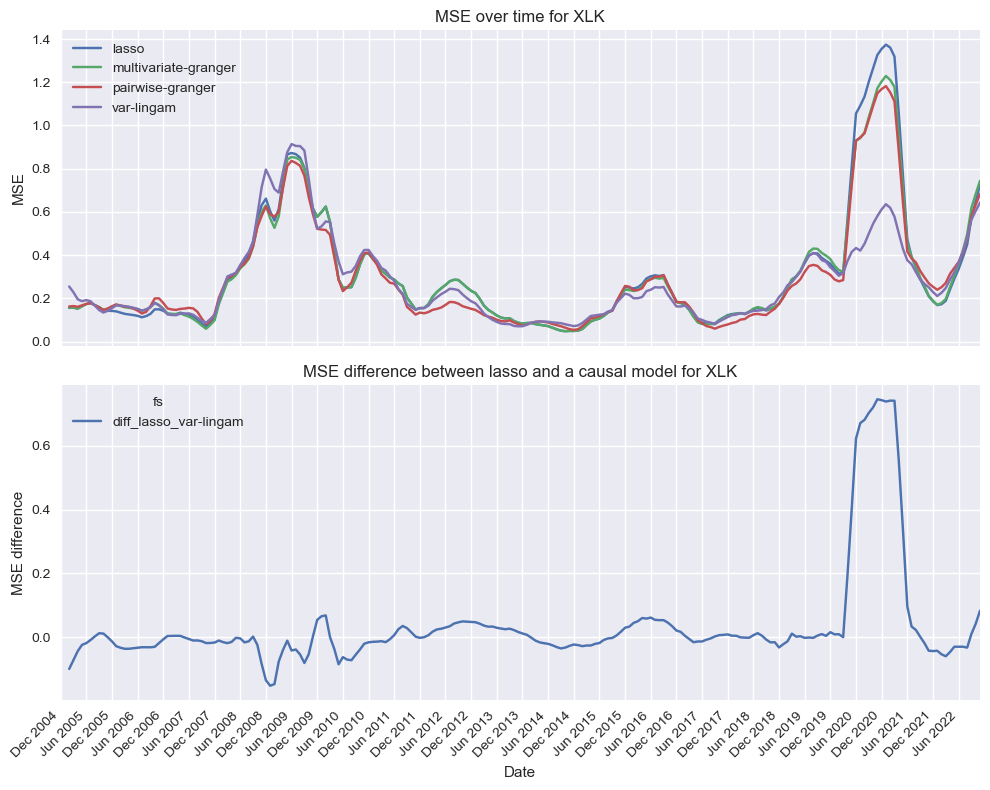

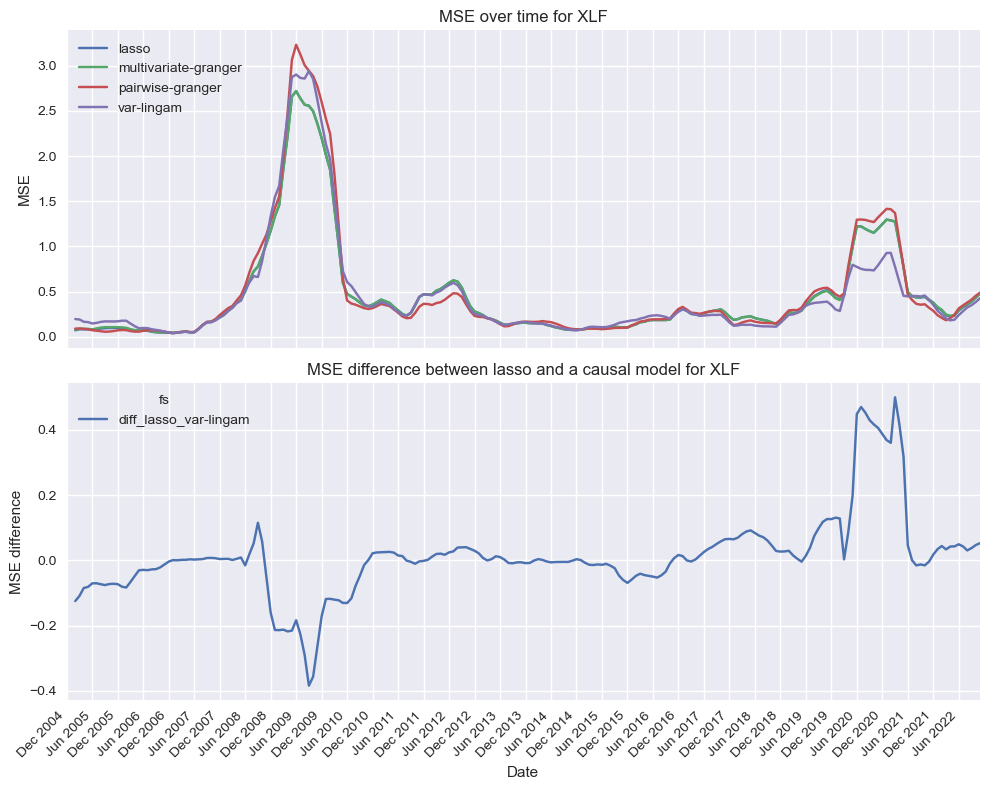

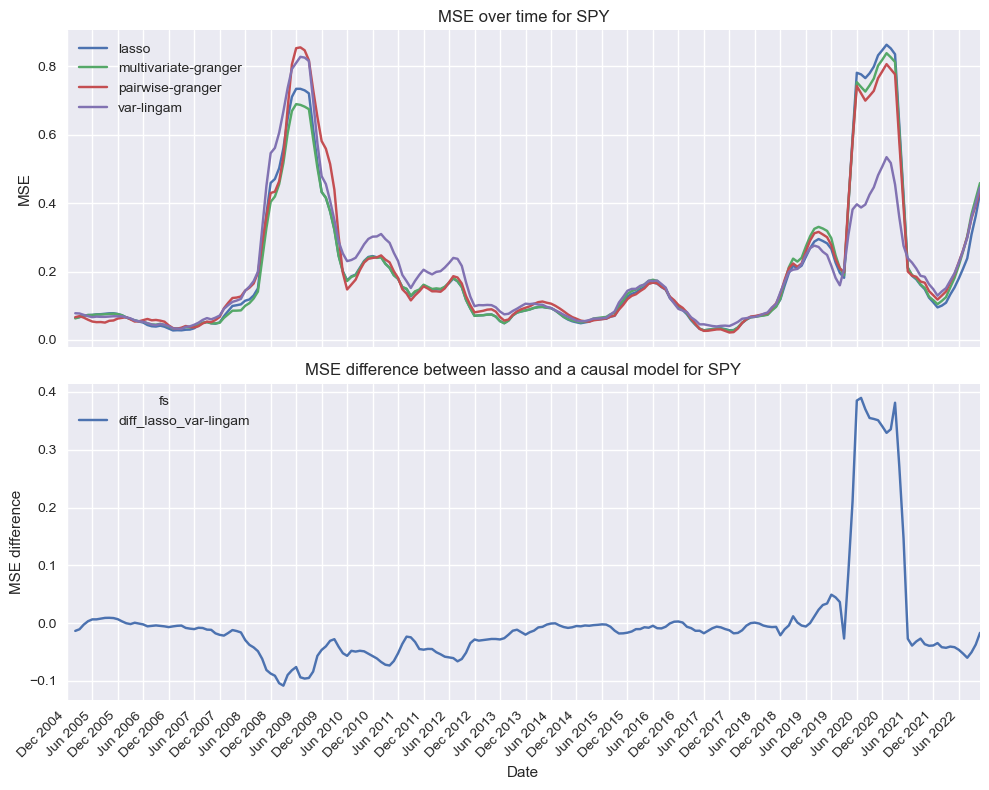

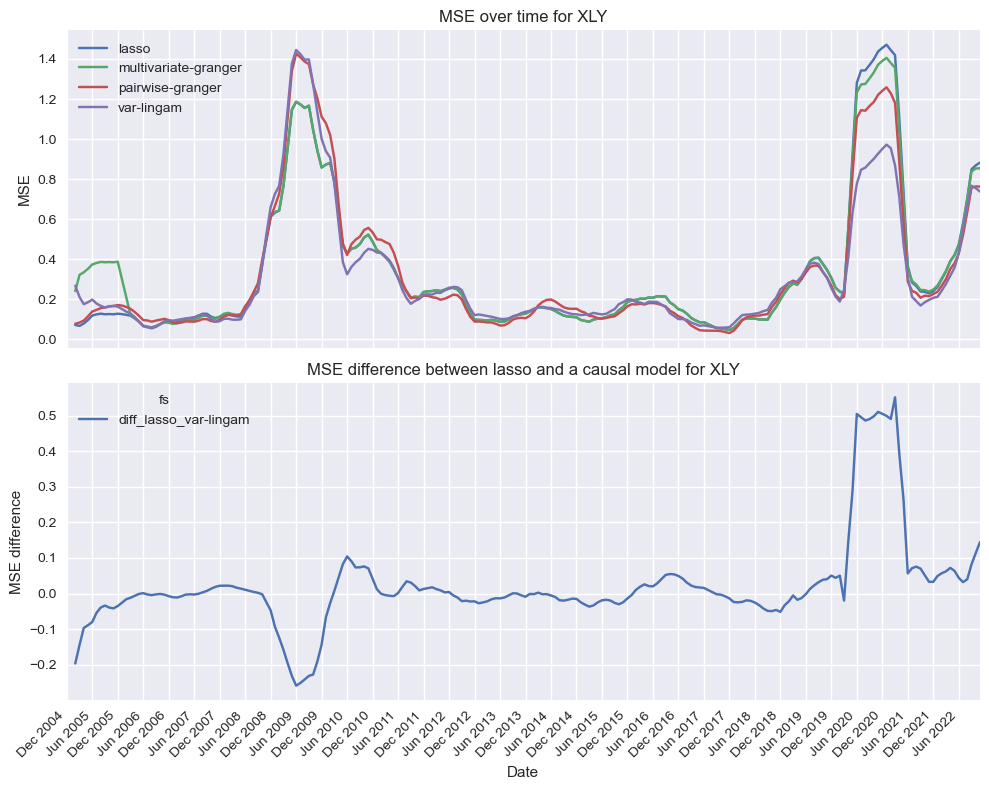

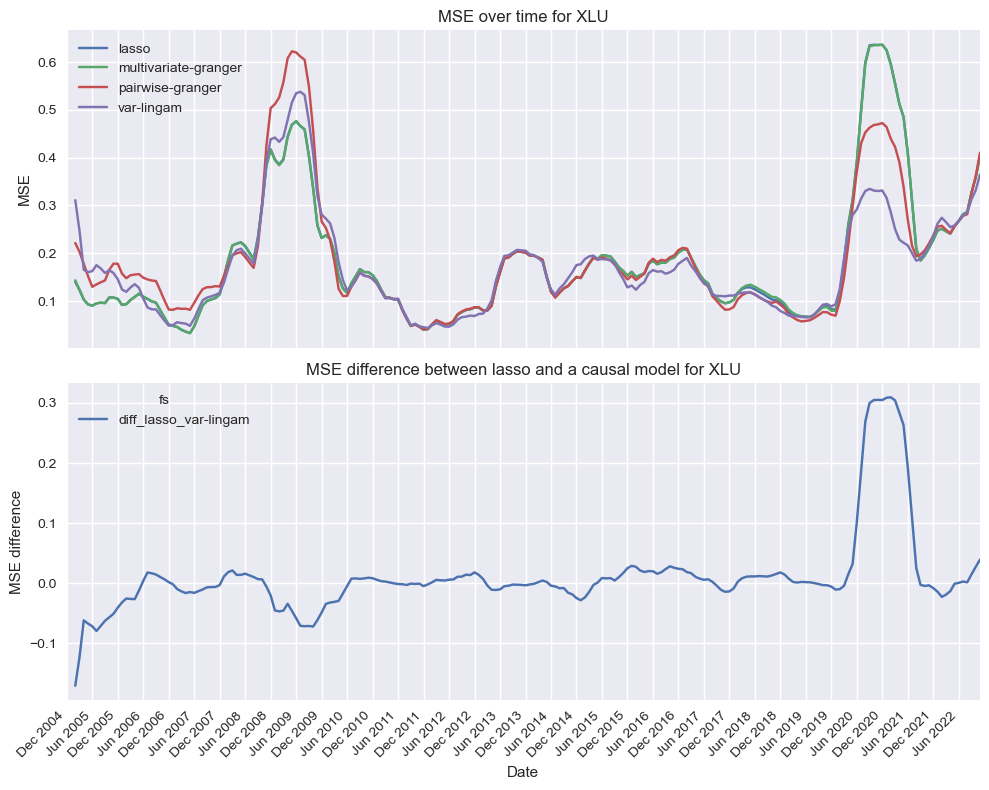

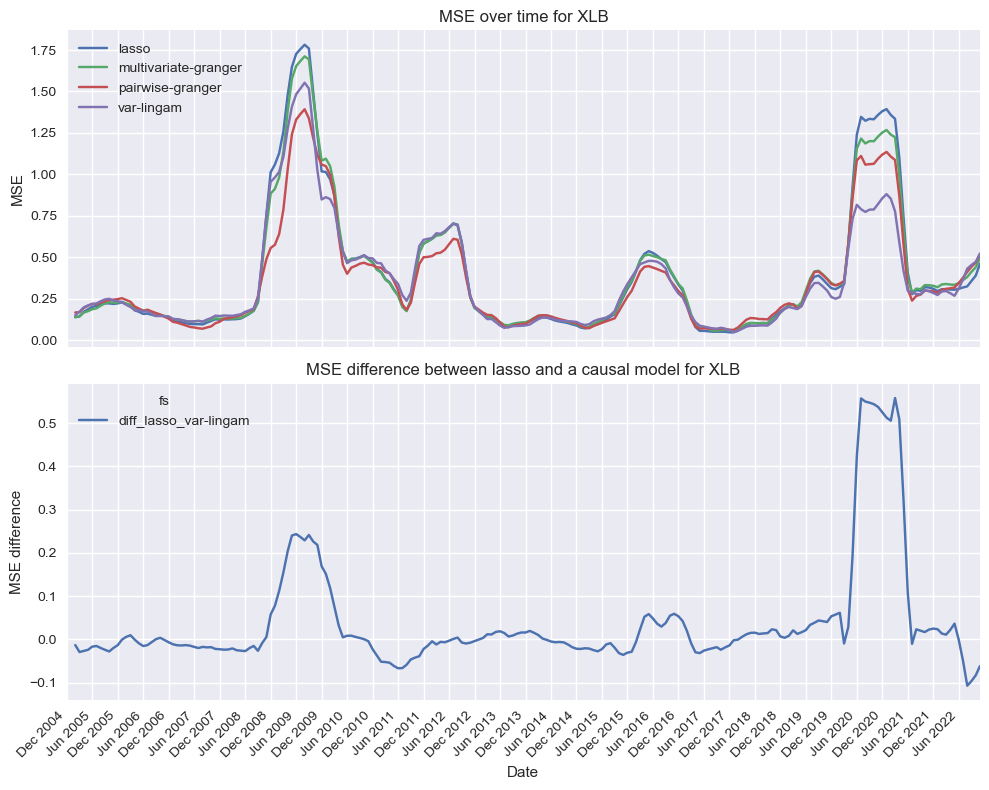

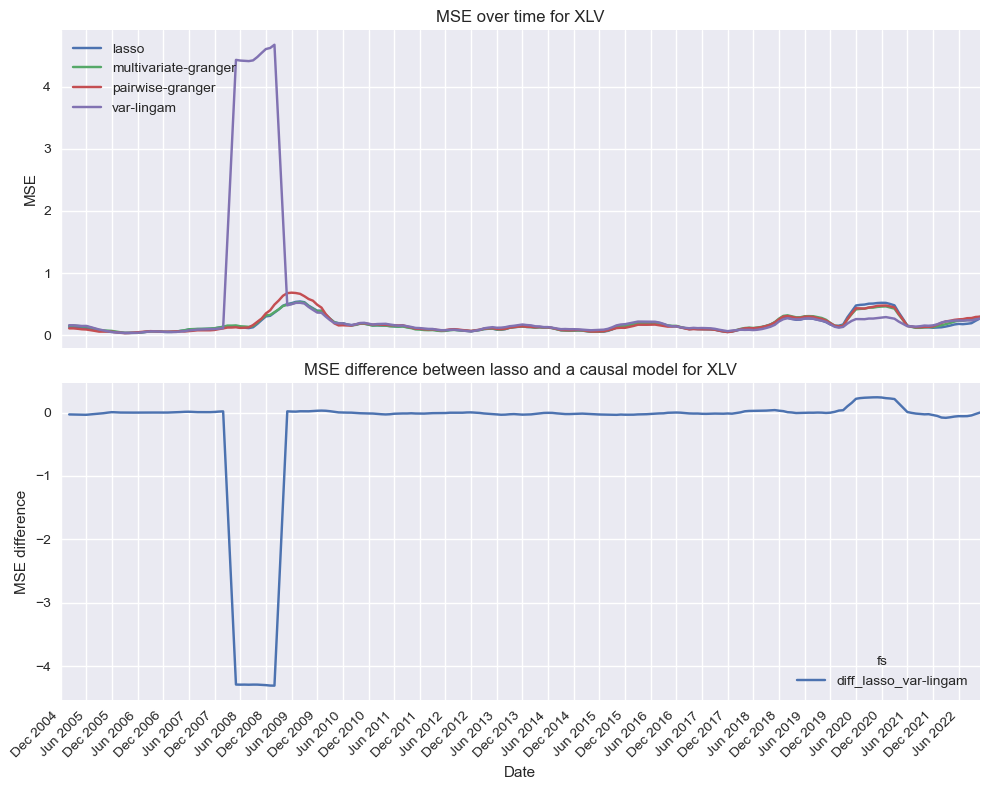

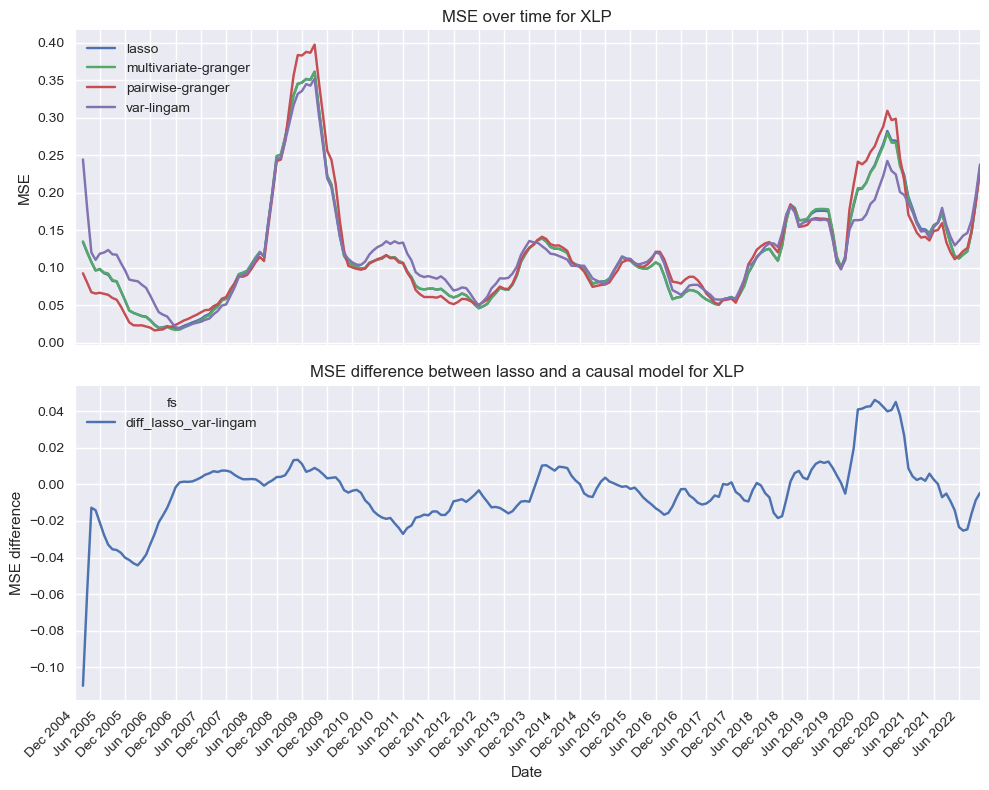

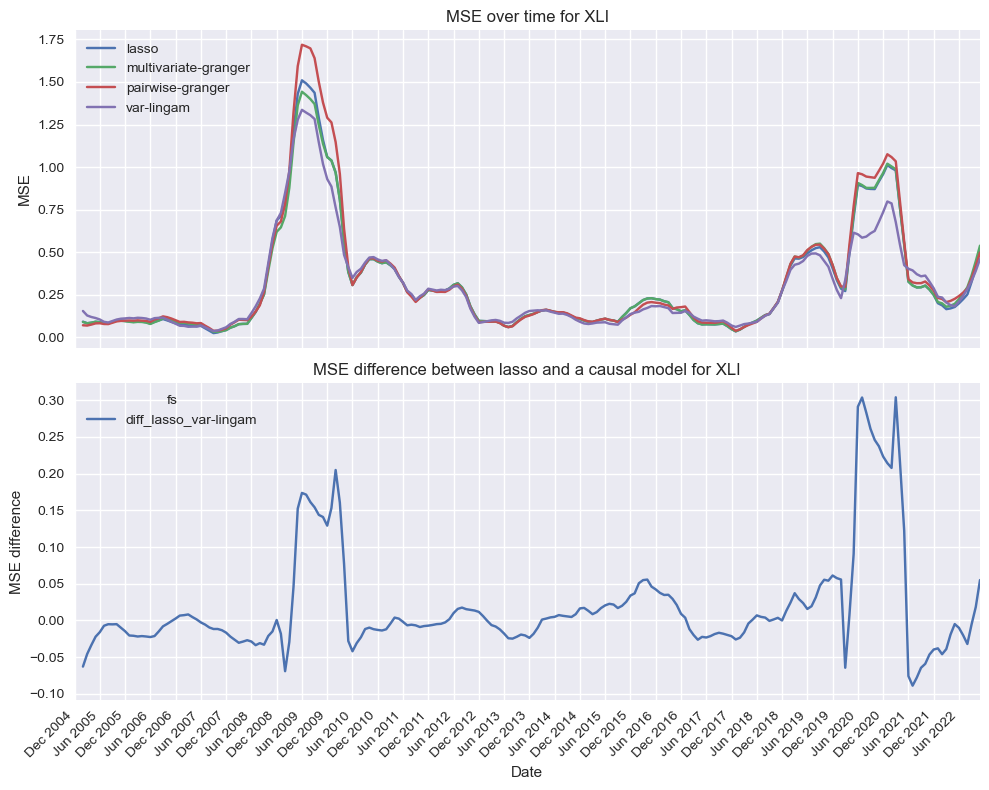

In [32]:
# SPY, XLP, XLK, XLY, XLF, XLB, XLI 

for etf in all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df = etf_rolling_metrics_df.rolling(3).mean()
    etf_rolling_metrics_df["diff_lasso_var-lingam"] = etf_rolling_metrics_df["lasso"] - etf_rolling_metrics_df["var-lingam"]
    # etf_rolling_metrics_df["diff_lasso_dynotears"] = etf_rolling_metrics_df["lasso"] - etf_rolling_metrics_df["dynotears"]

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    # etf_rolling_metrics_df.drop(["diff_lasso_var-lingam", "diff_lasso_dynotears"], axis=1).plot(ax=axs[0])
    etf_rolling_metrics_df.drop(["diff_lasso_var-lingam"], axis=1).plot(ax=axs[0])
    axs[0].set_title(f'MSE over time for {etf}')
    axs[0].set_ylabel('MSE')
    axs[0].legend(loc='upper left')

    # Plotting on the lower subplot
    # etf_rolling_metrics_df[["diff_lasso_var-lingam", "diff_lasso_dynotears"]].plot(ax=axs[1])
    etf_rolling_metrics_df[["diff_lasso_var-lingam"]].plot(ax=axs[1])
    axs[1].set_title(f'MSE difference between lasso and a causal model for {etf}')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('MSE difference')

    # Adding months and years to the index of the plot
    tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plot
    plt.show()

## Selected parents over time

In [33]:
etf = "SPY"
fss = ["var-lingam", "multivariate-granger"]

In [34]:
# select rows that match conditions fss
selected_melt_df = all_parents_df.loc[(all_parents_df["fs"] == fss[0]) & (all_parents_df["etf"] == etf)]

selected_melt_df.pivot_table(index=["date"], columns=["etf", "fs", "cluster"], values=["value"]).loc["2020-01-01":"2020-05-01"]

value                                                         \
etf               SPY                                                          
fs         var-lingam                                                          
cluster          0.0  4.0  6.0  7.0  8.0  9.0  10.0 12.0 13.0 15.0 16.0 18.0   
date                                                                           
2020-04-30        NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                 
etf              
fs               
cluster    19.0  
date             
2020-04-30  NaN

In [35]:
# select rows that match conditions fss
selected_melt_df = all_parents_df.loc[(all_parents_df["fs"] == fss[1]) & (all_parents_df["etf"] == etf)]

selected_melt_df.pivot_table(index=["date"], columns=["etf", "fs", "cluster"], values=["value"]).loc["2020-01-01":"2020-05-01"]

value                                               \
etf                         SPY                                                
fs         multivariate-granger                                                
cluster                    0.0  1.0  2.0  8.0  9.0  10.0 12.0 14.0 15.0 16.0   
date                                                                           
2020-01-31                  NaN  NaN  1.0  NaN  1.0  NaN  NaN  NaN  1.0  1.0   
2020-02-29                  NaN  NaN  1.0  NaN  1.0  NaN  NaN  NaN  1.0  1.0   
2020-03-31                  NaN  NaN  1.0  NaN  1.0  NaN  NaN  NaN  1.0  1.0   
2020-04-30                  NaN  NaN  1.0  NaN  1.0  NaN  NaN  NaN  NaN  1.0   

                 
etf              
fs               
cluster    17.0  
date             
2020-01-31  NaN  
2020-02-29  NaN  
2020-03-31  1.0  
2020-04-30  NaN

## Table of summary statistics

In [36]:
etf = "XLP"

all_metrics_df[all_metrics_df.index.isin([etf], level=1)].sort_values(by="mse", ascending=True)

,,mse,mae,mse_2020,mae_2020,stability
fs,etf,,,,,
lasso,XLP,0.001247,0.027749,0.002990,0.047255,0.128938
multivariate-granger,XLP,0.001247,0.027615,0.002961,0.046559,0.115285
pairwise-granger,XLP,0.001248,0.027216,0.003229,0.044722,0.261209
var-lingam,XLP,0.001353,0.028626,0.002533,0.041580,0.214286


In [37]:
all_metrics_df.sort_values(by=["mse"], ascending=True)

,,mse,mae,mse_2020,mae_2020,stability
fs,etf,,,,,
lasso,XLP,0.001247,0.027749,0.002990,0.047255,0.128938
multivariate-granger,XLP,0.001247,0.027615,0.002961,0.046559,0.115285
pairwise-granger,XLP,0.001248,0.027216,0.003229,0.044722,0.261209
var-lingam,XLP,0.001353,0.028626,0.002533,0.041580,0.214286
lasso,XLV,0.001747,0.032192,0.005626,0.059463,0.209393
multivariate-granger,XLV,0.001766,0.032306,0.005062,0.056096,0.175737
pairwise-granger,XLV,0.001798,0.032129,0.005204,0.058207,0.477974
var-lingam,XLU,0.001867,0.033742,0.003540,0.049063,0.186885
lasso,XLU,0.001900,0.033038,0.006838,0.069137,0.115385


In [38]:
all_metrics_df.sort_values(by="mae", ascending=True)

mse       mae  mse_2020  mae_2020  stability
fs                   etf                                                   
pairwise-granger     XLP  0.001248  0.027216  0.003229  0.044722   0.261209
multivariate-granger XLP  0.001247  0.027615  0.002961  0.046559   0.115285
lasso                XLP  0.001247  0.027749  0.002990  0.047255   0.128938
var-lingam           XLP  0.001353  0.028626  0.002533  0.041580   0.214286
pairwise-granger     XLV  0.001798  0.032129  0.005204  0.058207   0.477974
lasso                XLV  0.001747  0.032192  0.005626  0.059463   0.209393
                     SPY  0.001990  0.032271  0.009264  0.070579   0.324675
multivariate-granger XLV  0.001766  0.032306  0.005062  0.056096   0.175737
pairwise-granger     SPY  0.002056  0.032334  0.008708  0.064620   0.355727
multivariate-granger SPY  0.001983  0.032360  0.009038  0.068672   0.274058
lasso                XLU  0.001900  0.033038  0.006838  0.069137   0.115385
multivariate-granger XLU  0.001906  0.033159  0.006838  0.069137   0.116746
var-lingam           XLU  0.001867  0.033742  0.003540  0.049063   0.186885
pairwise-granger     XLU  0.001972  0.033986  0.005105  0.062317   0.164806
var-lingam           SPY  0.002004  0.034118  0.005755  0.064508   0.137410
                     XLV  0.003916  0.034561  0.003080  0.047738   0.269231
lasso                XLI  0.003152  0.039438  0.010837  0.075689   0.164984
multivariate-granger XLI  0.003136  0.039640  0.010918  0.076219   0.152802
var-lingam           XLI  0.002965  0.039767  0.008628  0.069709   0.135922
pairwise-granger     XLY  0.003286  0.040671  0.013666  0.085625   0.318807
lasso                XLY  0.003355  0.040674  0.015953  0.089989   0.277882
pairwise-granger     XLI  0.003288  0.040708  0.011524  0.080526   0.228781
multivariate-granger XLY  0.003445  0.041041  0.015246  0.088992   0.271582
var-lingam           XLY  0.003210  0.041097  0.010544  0.081413   0.164444
pairwise-granger     XLK  0.003019  0.041376  0.012718  0.093805   0.347527
multivariate-granger XLK  0.003139  0.042334  0.013209  0.098833   0.300641
lasso                XLK  0.003213  0.042749  0.014706  0.104552   0.317708
var-lingam           XLK  0.002882  0.042925  0.006749  0.077455   0.428571
pairwise-granger     XLB  0.003569  0.043791  0.012387  0.079481   0.411294
var-lingam           XLB  0.003567  0.044003  0.009645  0.077886   0.176292
lasso                XLB  0.003946  0.044964  0.015196  0.085609   0.270513
multivariate-granger XLB  0.003901  0.045261  0.013836  0.083768   0.239583
pairwise-granger     XLF  0.004721  0.047490  0.015267  0.095043   0.350367
var-lingam           XLF  0.004460  0.047632  0.009888  0.071321   0.207329
lasso                XLF  0.004515  0.047835  0.013962  0.089221   0.149616
multivariate-granger XLF  0.004522  0.048012  0.013962  0.089221   0.143349
                     XLE  0.006336  0.055658  0.037930  0.158611   0.173016
var-lingam           XLE  0.006133  0.056120  0.034813  0.137261   0.254579
lasso                XLE  0.006422  0.057303  0.040369  0.176325   0.223617
pairwise-granger     XLE  0.006804  0.057347  0.046253  0.163041   0.360289

In [39]:
all_metrics_df.sort_values(by="stability", ascending=False)

mse       mae  mse_2020  mae_2020  stability
fs                   etf                                                   
pairwise-granger     XLV  0.001798  0.032129  0.005204  0.058207   0.477974
var-lingam           XLK  0.002882  0.042925  0.006749  0.077455   0.428571
pairwise-granger     XLB  0.003569  0.043791  0.012387  0.079481   0.411294
                     XLE  0.006804  0.057347  0.046253  0.163041   0.360289
                     SPY  0.002056  0.032334  0.008708  0.064620   0.355727
                     XLF  0.004721  0.047490  0.015267  0.095043   0.350367
                     XLK  0.003019  0.041376  0.012718  0.093805   0.347527
lasso                SPY  0.001990  0.032271  0.009264  0.070579   0.324675
pairwise-granger     XLY  0.003286  0.040671  0.013666  0.085625   0.318807
lasso                XLK  0.003213  0.042749  0.014706  0.104552   0.317708
multivariate-granger XLK  0.003139  0.042334  0.013209  0.098833   0.300641
lasso                XLY  0.003355  0.040674  0.015953  0.089989   0.277882
multivariate-granger SPY  0.001983  0.032360  0.009038  0.068672   0.274058
                     XLY  0.003445  0.041041  0.015246  0.088992   0.271582
lasso                XLB  0.003946  0.044964  0.015196  0.085609   0.270513
var-lingam           XLV  0.003916  0.034561  0.003080  0.047738   0.269231
pairwise-granger     XLP  0.001248  0.027216  0.003229  0.044722   0.261209
var-lingam           XLE  0.006133  0.056120  0.034813  0.137261   0.254579
multivariate-granger XLB  0.003901  0.045261  0.013836  0.083768   0.239583
pairwise-granger     XLI  0.003288  0.040708  0.011524  0.080526   0.228781
lasso                XLE  0.006422  0.057303  0.040369  0.176325   0.223617
var-lingam           XLP  0.001353  0.028626  0.002533  0.041580   0.214286
lasso                XLV  0.001747  0.032192  0.005626  0.059463   0.209393
var-lingam           XLF  0.004460  0.047632  0.009888  0.071321   0.207329
                     XLU  0.001867  0.033742  0.003540  0.049063   0.186885
                     XLB  0.003567  0.044003  0.009645  0.077886   0.176292
multivariate-granger XLV  0.001766  0.032306  0.005062  0.056096   0.175737
                     XLE  0.006336  0.055658  0.037930  0.158611   0.173016
lasso                XLI  0.003152  0.039438  0.010837  0.075689   0.164984
pairwise-granger     XLU  0.001972  0.033986  0.005105  0.062317   0.164806
var-lingam           XLY  0.003210  0.041097  0.010544  0.081413   0.164444
multivariate-granger XLI  0.003136  0.039640  0.010918  0.076219   0.152802
lasso                XLF  0.004515  0.047835  0.013962  0.089221   0.149616
multivariate-granger XLF  0.004522  0.048012  0.013962  0.089221   0.143349
var-lingam           SPY  0.002004  0.034118  0.005755  0.064508   0.137410
                     XLI  0.002965  0.039767  0.008628  0.069709   0.135922
lasso                XLP  0.001247  0.027749  0.002990  0.047255   0.128938
multivariate-granger XLU  0.001906  0.033159  0.006838  0.069137   0.116746
lasso                XLU  0.001900  0.033038  0.006838  0.069137   0.115385
multivariate-granger XLP  0.001247  0.027615  0.002961  0.046559   0.115285

In [40]:
all_metrics_df.sort_values(by="mse_2020", ascending=True)

mse       mae  mse_2020  mae_2020  stability
fs                   etf                                                   
var-lingam           XLP  0.001353  0.028626  0.002533  0.041580   0.214286
multivariate-granger XLP  0.001247  0.027615  0.002961  0.046559   0.115285
lasso                XLP  0.001247  0.027749  0.002990  0.047255   0.128938
var-lingam           XLV  0.003916  0.034561  0.003080  0.047738   0.269231
pairwise-granger     XLP  0.001248  0.027216  0.003229  0.044722   0.261209
var-lingam           XLU  0.001867  0.033742  0.003540  0.049063   0.186885
multivariate-granger XLV  0.001766  0.032306  0.005062  0.056096   0.175737
pairwise-granger     XLU  0.001972  0.033986  0.005105  0.062317   0.164806
                     XLV  0.001798  0.032129  0.005204  0.058207   0.477974
lasso                XLV  0.001747  0.032192  0.005626  0.059463   0.209393
var-lingam           SPY  0.002004  0.034118  0.005755  0.064508   0.137410
                     XLK  0.002882  0.042925  0.006749  0.077455   0.428571
multivariate-granger XLU  0.001906  0.033159  0.006838  0.069137   0.116746
lasso                XLU  0.001900  0.033038  0.006838  0.069137   0.115385
var-lingam           XLI  0.002965  0.039767  0.008628  0.069709   0.135922
pairwise-granger     SPY  0.002056  0.032334  0.008708  0.064620   0.355727
multivariate-granger SPY  0.001983  0.032360  0.009038  0.068672   0.274058
lasso                SPY  0.001990  0.032271  0.009264  0.070579   0.324675
var-lingam           XLB  0.003567  0.044003  0.009645  0.077886   0.176292
                     XLF  0.004460  0.047632  0.009888  0.071321   0.207329
                     XLY  0.003210  0.041097  0.010544  0.081413   0.164444
lasso                XLI  0.003152  0.039438  0.010837  0.075689   0.164984
multivariate-granger XLI  0.003136  0.039640  0.010918  0.076219   0.152802
pairwise-granger     XLI  0.003288  0.040708  0.011524  0.080526   0.228781
                     XLB  0.003569  0.043791  0.012387  0.079481   0.411294
                     XLK  0.003019  0.041376  0.012718  0.093805   0.347527
multivariate-granger XLK  0.003139  0.042334  0.013209  0.098833   0.300641
pairwise-granger     XLY  0.003286  0.040671  0.013666  0.085625   0.318807
multivariate-granger XLB  0.003901  0.045261  0.013836  0.083768   0.239583
lasso                XLF  0.004515  0.047835  0.013962  0.089221   0.149616
multivariate-granger XLF  0.004522  0.048012  0.013962  0.089221   0.143349
lasso                XLK  0.003213  0.042749  0.014706  0.104552   0.317708
                     XLB  0.003946  0.044964  0.015196  0.085609   0.270513
multivariate-granger XLY  0.003445  0.041041  0.015246  0.088992   0.271582
pairwise-granger     XLF  0.004721  0.047490  0.015267  0.095043   0.350367
lasso                XLY  0.003355  0.040674  0.015953  0.089989   0.277882
var-lingam           XLE  0.006133  0.056120  0.034813  0.137261   0.254579
multivariate-granger XLE  0.006336  0.055658  0.037930  0.158611   0.173016
lasso                XLE  0.006422  0.057303  0.040369  0.176325   0.223617
pairwise-granger     XLE  0.006804  0.057347  0.046253  0.163041   0.360289

In [41]:
all_metrics_df.sort_values(by="mse", ascending=True)

,,mse,mae,mse_2020,mae_2020,stability
fs,etf,,,,,
lasso,XLP,0.001247,0.027749,0.002990,0.047255,0.128938
multivariate-granger,XLP,0.001247,0.027615,0.002961,0.046559,0.115285
pairwise-granger,XLP,0.001248,0.027216,0.003229,0.044722,0.261209
var-lingam,XLP,0.001353,0.028626,0.002533,0.041580,0.214286
lasso,XLV,0.001747,0.032192,0.005626,0.059463,0.209393
multivariate-granger,XLV,0.001766,0.032306,0.005062,0.056096,0.175737
pairwise-granger,XLV,0.001798,0.032129,0.005204,0.058207,0.477974
var-lingam,XLU,0.001867,0.033742,0.003540,0.049063,0.186885
lasso,XLU,0.001900,0.033038,0.006838,0.069137,0.115385


<AxesSubplot:xlabel='stability', ylabel='mae'>

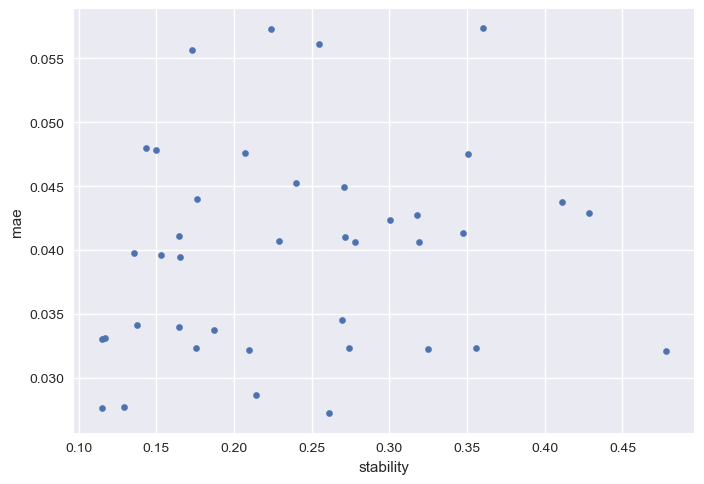

In [42]:
all_metrics_df.plot.scatter(y="mae", x="stability")

<AxesSubplot:xlabel='stability', ylabel='mae_2020'>

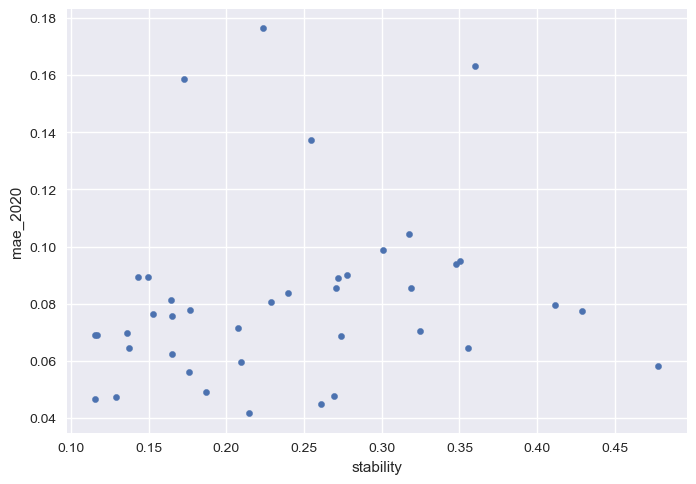

In [43]:
all_metrics_df.plot.scatter(y="mae_2020", x="stability")

<AxesSubplot:xlabel='stability', ylabel='mse'>

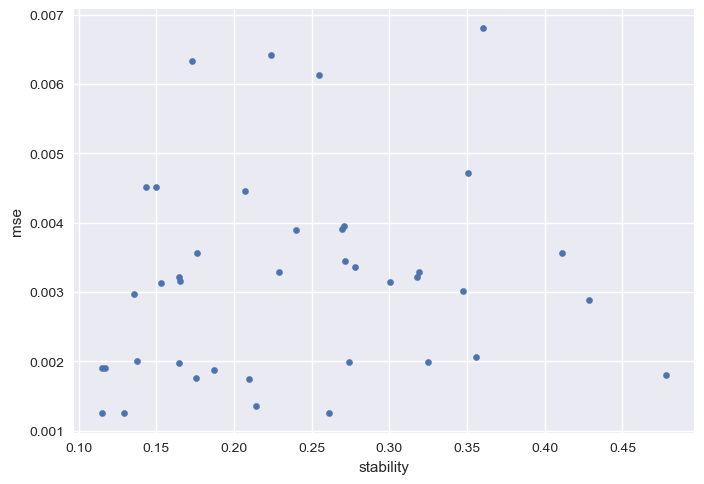

In [44]:
all_metrics_df.plot.scatter(y="mse", x="stability")

<AxesSubplot:xlabel='stability', ylabel='mse_2020'>

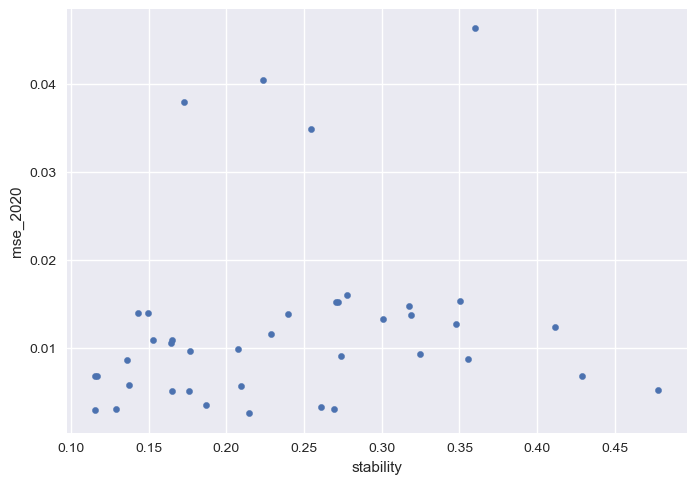

In [45]:
all_metrics_df.plot.scatter(y="mse_2020", x="stability")